<a href="https://colab.research.google.com/github/RezuanChowdhuryRifat/SETI-Signal-Classification/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import seaborn as sns
import tensorflow as tf

# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


**Preprocessing**

In [4]:
train_path = "/content/drive/MyDrive/dataset/train"
test_path = "/content/drive/MyDrive/dataset/test"
valid_path = "/content/drive/MyDrive/dataset/valid"


SIZE = 256  #Resize images
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path, image_size=(SIZE,SIZE),batch_size=batch_size, shuffle=True,
                                                               seed=123, label_mode='categorical')
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_path, image_size=(SIZE,SIZE),batch_size=batch_size, shuffle=False,
                                                               seed=123, label_mode='categorical')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path, image_size=(SIZE,SIZE), batch_size=batch_size, shuffle=False,
                                                              seed=123, label_mode='categorical')

Found 5600 files belonging to 7 classes.
Found 700 files belonging to 7 classes.
Found 700 files belonging to 7 classes.


**Plot data**

Found 700 files belonging to 7 classes.


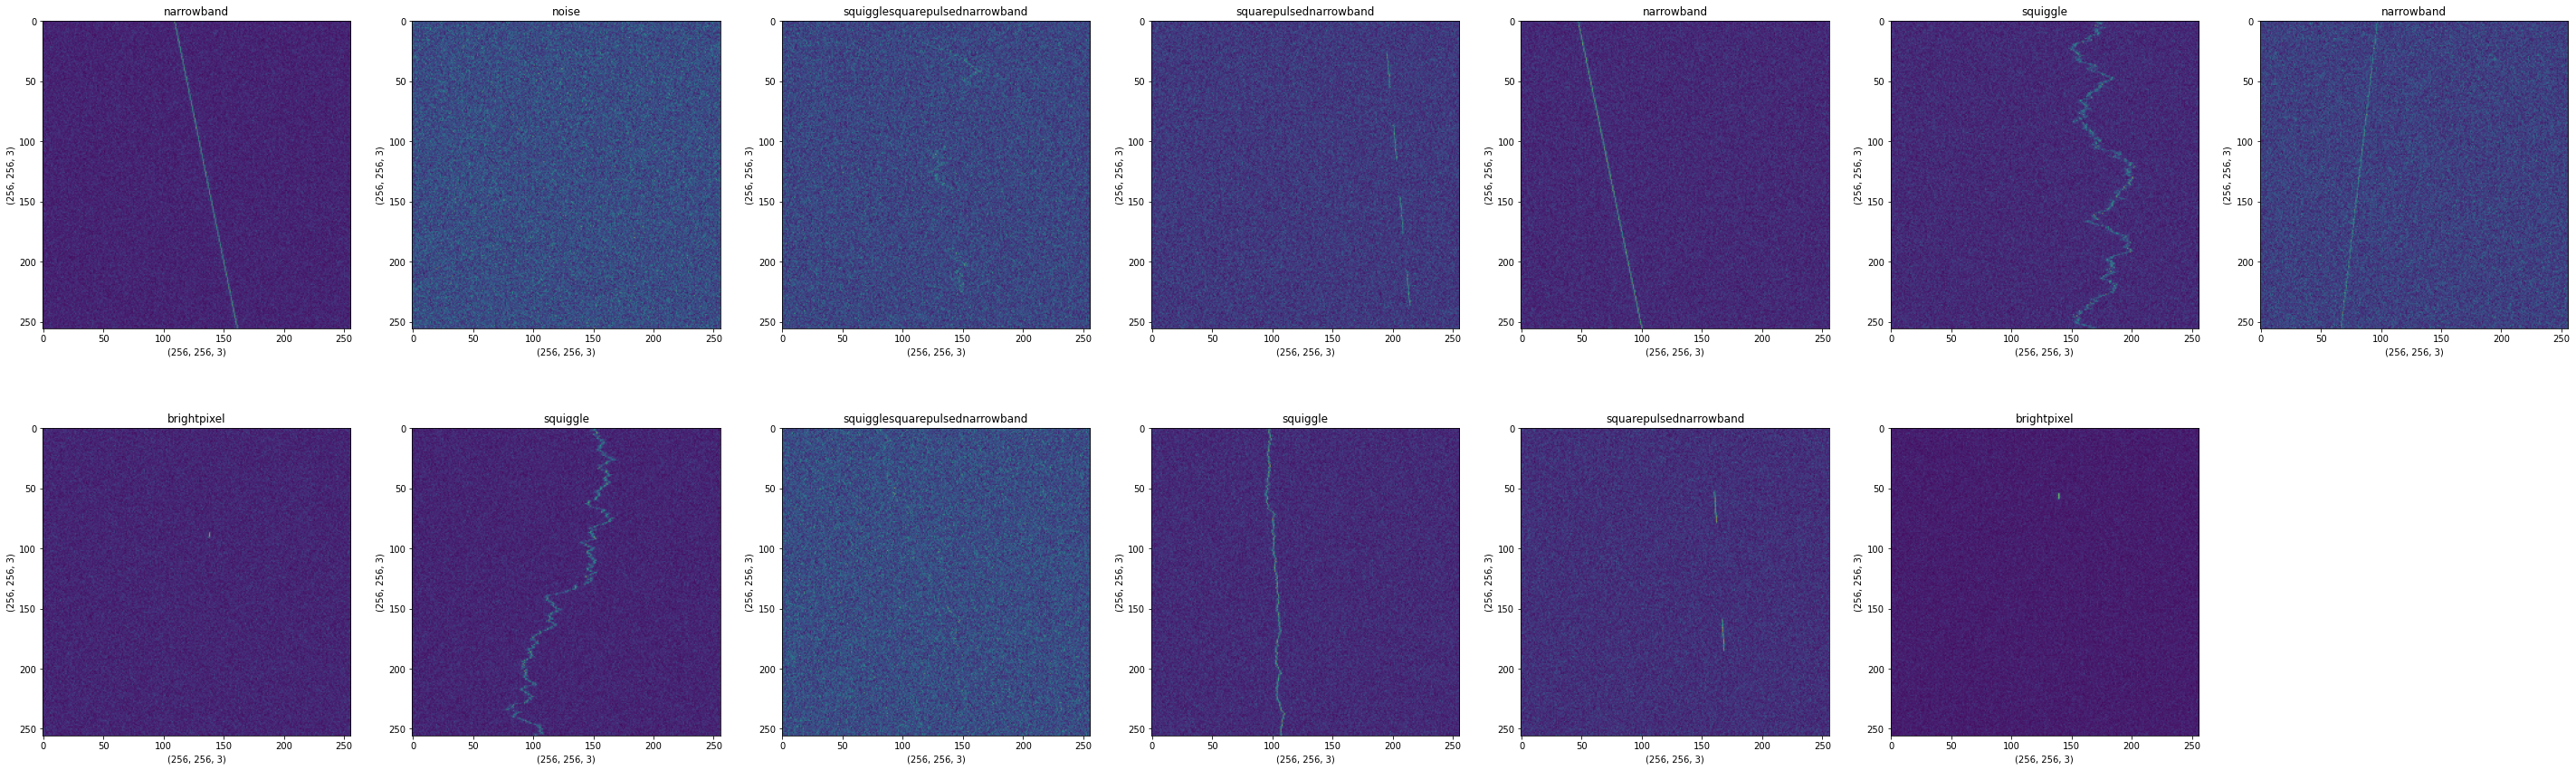

In [5]:
x_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_path, image_size=(SIZE,SIZE),batch_size=batch_size, shuffle=True,)
classes_list = sorted(os.listdir(valid_path))
plt.figure(figsize=(50, 40))
for images, labels in x_ds.take(1):
    for i in range(1, 14):
        plt.subplot(5, 7, i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_list[labels[i]])
        plt.xlabel(images[i].numpy().astype("uint8").shape)
        plt.ylabel(images[i].numpy().astype("uint8").shape)

**Check input shape**

In [6]:
for img_batch, label_batch in x_ds.take(1):
    print('image batch shape: ', img_batch.shape)
    print('label_batch shape: ', label_batch.shape)

image batch shape:  (32, 256, 256, 3)
label_batch shape:  (32,)


# Model

In [7]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights= "imagenet",
    input_shape=(256,256,3),
    classes=7,
)

base_model.summary()
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

82420632/82420632 [==============================] - 0s 0us/step
Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                  

In [8]:
model.compile(loss="categorical_crossentropy",optimizer="adam",
                       metrics=["accuracy"])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

**Training**

In [10]:
history = model.fit(train_ds, epochs= 20, batch_size=32, validation_data=valid_ds)

Epoch 1/20
175/175 [==============================] - 587s 3s/step - loss: 0.6822 - accuracy: 0.7730 - val_loss: 0.5265 - val_accuracy: 0.8329
Epoch 2/20
175/175 [==============================] - 54s 297ms/step - loss: 0.5772 - accuracy: 0.8061 - val_loss: 0.5201 - val_accuracy: 0.8371
Epoch 3/20
175/175 [==============================] - 55s 305ms/step - loss: 0.5464 - accuracy: 0.8218 - val_loss: 0.4831 - val_accuracy: 0.8329
Epoch 4/20
175/175 [==============================] - 51s 283ms/step - loss: 0.5490 - accuracy: 0.8168 - val_loss: 0.5355 - val_accuracy: 0.8300
Epoch 5/20
175/175 [==============================] - 51s 283ms/step - loss: 0.5206 - accuracy: 0.8288 - val_loss: 0.4905 - val_accuracy: 0.8543
Epoch 6/20
175/175 [==============================] - 51s 281ms/step - loss: 0.5094 - accuracy: 0.8325 - val_loss: 0.4678 - val_accuracy: 0.8486
Epoch 7/20
175/175 [==============================] - 50s 278ms/step - loss: 0.5077 - accuracy: 0.8307 - val_loss: 0.4669 - val_accu

**Plot graph**

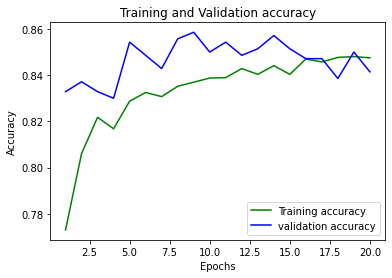

In [12]:
accuracy = history.history['accuracy']
accuracy_val= history.history['val_accuracy']
epochs= range(1,21)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

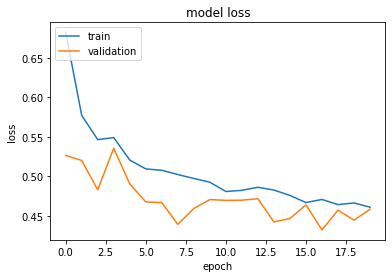

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Testing**

In [14]:
model.evaluate(test_ds)

22/22 [==============================] - 67s 3s/step - loss: 0.4860 - accuracy: 0.8400


[0.4860331118106842, 0.8399999737739563]

**Save model**

In [15]:
model.save("/content/drive/MyDrive/dataset/efficientnetv2")

**Unfreeze last 20 layers**

In [16]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

**Training**

In [17]:
history = model.fit(train_ds, epochs= 20, batch_size=32, validation_data=valid_ds)

Epoch 1/20
175/175 [==============================] - 78s 357ms/step - loss: 0.4516 - accuracy: 0.8541 - val_loss: 0.4086 - val_accuracy: 0.8657
Epoch 2/20
175/175 [==============================] - 53s 293ms/step - loss: 0.4457 - accuracy: 0.8500 - val_loss: 0.4481 - val_accuracy: 0.8529
Epoch 3/20
175/175 [==============================] - 54s 286ms/step - loss: 0.4349 - accuracy: 0.8534 - val_loss: 0.4153 - val_accuracy: 0.8529
Epoch 4/20
175/175 [==============================] - 52s 288ms/step - loss: 0.4284 - accuracy: 0.8568 - val_loss: 0.4126 - val_accuracy: 0.8643
Epoch 5/20
175/175 [==============================] - 52s 287ms/step - loss: 0.4185 - accuracy: 0.8600 - val_loss: 0.4251 - val_accuracy: 0.8600
Epoch 6/20
175/175 [==============================] - 51s 282ms/step - loss: 0.4329 - accuracy: 0.8575 - val_loss: 0.4374 - val_accuracy: 0.8471
Epoch 7/20
175/175 [==============================] - 52s 289ms/step - loss: 0.4173 - accuracy: 0.8618 - val_loss: 0.4062 - val_ac

**Plot grapgh**

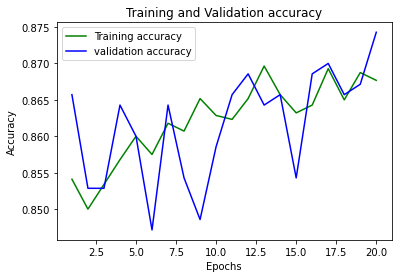

In [18]:
accuracy = history.history['accuracy']
accuracy_val= history.history['val_accuracy']
epochs= range(1,21)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

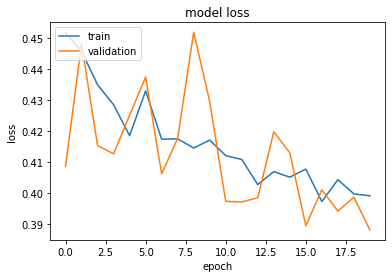

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Testing**

In [20]:
model.evaluate(test_ds)

22/22 [==============================] - 7s 297ms/step - loss: 0.3941 - accuracy: 0.8629


[0.3941010534763336, 0.8628571629524231]

**Save model**

In [21]:
model.save("/content/drive/MyDrive/dataset/efficientnetv2.1")